<a href="https://colab.research.google.com/github/janinerottmann/Practical-Data-Science/blob/master/3.%20Predicting%20Video%20Game%20Sales%20with%20Deep%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Practical Data Science 19/20*
# Programming Assignment 3 - Predicting Video Game Sales with Deep Learning

In this programming assignment, you need to apply your new deep learning knowledge. In contrast to PA2, you don't have to bother about feature engineering. You will build an artificial neural network with multiple layers that learns features from the raw data.

## Introduction and Dataset

You are provided with a dataset containing a list of video games with sales greater than 100.000 copies. Again, your task is to build a model predicting the yearly global sales (column ``Global_Sales``) of a video game leveraging the available features.

To help you get started, the following blocks of code import the dataset using pandas: 

In [0]:
import pandas as pd

In [0]:
data_path = 'https://raw.githubusercontent.com/pds1920/_a2-template/master/data/video_game_sales.csv'
df = pd.read_csv(data_path)
df

,Name,Platform,Year_of_Release,Genre,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,Wii Sports,Wii,2006.0,Sports,82.53,76.0,51.0,8.0,322.0,E
1,Super Mario Bros.,NES,1985.0,Platform,40.24,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,35.52,82.0,73.0,8.3,709.0,E
3,Wii Sports Resort,Wii,2009.0,Sports,32.77,80.0,73.0,8.0,192.0,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,31.37,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
16706,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.01,NaN,NaN,NaN,NaN,NaN
16707,LMA Manager 2007,X360,2006.0,Sports,0.01,NaN,NaN,NaN,NaN,NaN
16708,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.01,NaN,NaN,NaN,NaN,NaN
16709,Spirits & Spells,GBA,2003.0,Platform,0.01,NaN,NaN,NaN,NaN,NaN


## Creating a DataBunch

First, import everything we need for the tabular model

In [0]:
from fastai import * 
from fastai.tabular import * 
from sklearn.model_selection import train_test_split

To create a `TabularDataBunch`, you need to assign the variables to dependent, categorical and continuous variables

In [0]:
dep_var = 'Global_Sales'
cat_names = ['Platform', 'Genre', 'Rating']
cont_names = ['Year_of_Release', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count']  #aren't those continous variables by default?

fast.ai contains classes that define [transformations](https://docs.fast.ai/tabular.transform.html) for preprocessing. Provide a list of appropriate preprocessing steps.

In [0]:
procs = TabularProc(cat_names, cont_names)
procs = [FillMissing, Categorify, Normalize]

You also need to define the train and validation set (using indices!). Make sure that the split is the same as in Assignment 2 (Note: Don't split the dataset at this point!)

In [0]:
train_idx, valid_idx = train_test_split(range(len(df)), test_size=0.2, random_state = 2) # I used random_state = 2 in assignment 2
train_idx[:5]

[13348, 15085, 12943, 16675, 8135]

Now you're ready to pass this information to `TabularDataBunch.from_df` to create the DataBunch that you'll use for training.

In [0]:
data = TabularDataBunch.from_df(path=data_path, df=df, dep_var=dep_var, valid_idx=valid_idx, 
                                procs=procs, cat_names=cat_names, cont_names=cont_names, bs=32)

How is the data target variable stored in the `DataBunch`? Report the data type using `type()`

In [0]:
type(data.y)
# target variable is stored in a FloatList (not in a column)

fastai.data_block.FloatList

## Modeling

### Create Learner

Create an [appropriate learner](https://docs.fast.ai/tabular.learner.html) for data. A learner creates a neural network for us.
- Use 100 nodes in the first and 50 nodes in the second layer
- Choose the [metrics](https://docs.fast.ai/metrics.html) *root mean squared error* and mean *absolute error*. You can pass a list of metrics to the learner.
- *Optional*: Specify the embedding size of one categorical variable

In [0]:
learn = tabular_learner(data, layers=[100,50], emb_szs={'Genre': 10}, metrics=[root_mean_squared_error, mean_absolute_error])

How many Embeddings are there in the model? Use `learn.data.show_batch()` to explain why!

In [0]:
learn.data.show_batch()
# 8 features, 1 target variable, but 14 Embeddings.
# Reason: New columns for NAs in feature variables.

Platform,Genre,Rating,Year_of_Release_na,Critic_Score_na,Critic_Count_na,User_Score_na,User_Count_na,Year_of_Release,Critic_Score,Critic_Count,User_Score,User_Count,target
PS,Racing,#na#,False,True,True,True,True,-1.2778,0.0995,-0.1929,0.0044,-0.1603,0.4
Wii,Simulation,E10+,False,False,False,False,False,0.4288,0.6159,1.3660,1.3663,-0.1578,0.86
XB,Misc,#na#,False,True,True,True,True,-0.5951,0.0995,-0.1929,0.0044,-0.1603,0.07
DS,Adventure,#na#,False,True,True,True,True,0.5995,0.0995,-0.1929,0.0044,-0.1603,0.07
PC,Action,M,False,True,True,False,False,-1.2778,0.0995,-0.1929,1.6645,0.0322,0.05


In [0]:
learn.summary()

TabularModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [11]                 352        True      
______________________________________________________________________
Embedding            [10]                 130        True      
______________________________________________________________________
Embedding            [5]                  45         True      
______________________________________________________________________
Embedding            [3]                  9          True      
______________________________________________________________________
Embedding            [3]                  9          True      
______________________________________________________________________
Embedding            [3]                  9          True      
______________________________________________________________________
Embedding            [3]                  9          True      
_________________________________________________

### Find the learning rate 
You need to find a suitable learning rate for the training
- Read the [docs](https://docs.fast.ai/callbacks.lr_finder.html) how to find the right learning rate
- Repeat this step until you get a nice plot ;)

In [0]:
# find learning rate
learn.lr_find(stop_div=False, num_it=50)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.75E-06
Min loss divided by 10: 1.10E-01


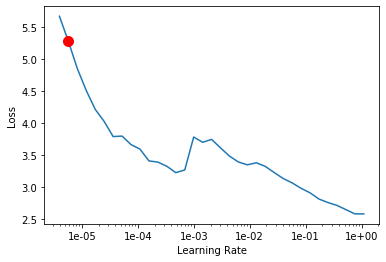

In [0]:
# plot
learn.recorder.plot(suggestion=True)

In [0]:
# identify the steepest section on the learning rate finder plot:
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

5.754399373371569e-06

### Fit the model

- How many epochs (cycles) are necessary to train the model? Is there a problem with overfitting?

In [0]:
learn.fit_one_cycle(12, max_lr=slice(min_grad_lr))

epoch,train_loss,valid_loss,root_mean_squared_error,mean_absolute_error,time
0,1.482600,1.714985,1.079739,0.509680,00:04
1,3.106540,1.704261,1.076313,0.521344,00:04
2,5.363592,1.714002,1.072338,0.514538,00:04
3,1.669675,1.655870,1.051793,0.516492,00:04
4,1.726115,1.675944,1.059237,0.516881,00:04
5,2.589095,1.644660,1.048094,0.514313,00:04
6,1.913048,1.590645,1.024964,0.497994,00:04
7,6.284645,1.634542,1.039293,0.495934,00:04
8,1.918719,1.592748,1.021793,0.486943,00:04
9,2.492945,1.603094,1.031153,0.499760,00:04


General observation:
- Performance seames to vary with the embedding variable (tested Rating vs. Genre), embedding size (tested 5-50)
and the number of iterations (tested 10-100)
- Overfitting occurs now and then. It can be identified when model has good performance on train set whereas valid set has high losses.
- Since DL is a blockbox I do not understand the processes in each layer and can not explain why results vary each time I run the code.

Evaluation of cycles:
- For multiple times I run the model with different parameters my general impression is that the performance increases within the first 5-7 iterations.
- After that the performance often stagnated, declined or overfitting kicked in.

### Evaluate the model

Report the in-sample as well as the out-of-sample performance usinge the mean absolute error.

In [0]:
learn.predict(df.iloc[1])

(FloatItem [0.869771], tensor([0.8698]), tensor([0.8698]))

In [0]:
learn.get_preds(ds_type=DatasetType.Valid)
learn.show_results(ds_type=DatasetType.Valid)

Platform,Genre,Rating,Year_of_Release_na,Critic_Score_na,Critic_Count_na,User_Score_na,User_Count_na,Year_of_Release,Critic_Score,Critic_Count,User_Score,User_Count,target,prediction
GC,Misc,E10+,False,False,False,False,True,-0.2538,-2.6890,-1.3805,0.0044,-0.1603,0.05,[-0.183101]
PC,Strategy,#na#,False,True,True,True,True,-0.9365,0.0995,-0.1929,0.0044,-0.1603,0.02,[0.122026]
DS,Sports,#na#,False,True,True,True,True,0.0875,0.0995,-0.1929,0.0044,-0.1603,0.08,[-0.02133]
DS,Misc,#na#,False,True,True,True,True,0.7702,0.0995,-0.1929,0.0044,-0.1603,0.04,[-0.094949]
GBA,Racing,E,False,False,False,False,True,-0.5951,-0.5202,-1.2321,0.0044,-0.1603,0.01,[0.150127]


## Discussion

Looking at the results, discuss the advantages and disadvantages of deep learning for tabular data.

Advantages of DL:
- can solve complex problems
- does not require feature engineering
- can flexibly adapt to new challenges
- due to high automation of libraries (such as fastai) DL is easily implemented

Disadvantages:
- requires large amount of data
- training requires powerful hardware and is time consuming
- as mentioned earlier: DL is a blackbox. Therefore understanding processing steps or how performance can be increased is difficult.